## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# # Retrieves the same columns as the test data for machine learning
# # Don't use this for exploring the data, there might be columns that we should be exploring
# df = pd.read_csv('../flights.csv')
# X = df[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
#        'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
#        'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
#        'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
#        'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance', 'arr_delay']]
# # X.drop(['mkt_unique_carrier', 'branded_code_share', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin_city_name', 'dest_airport_id', 
# #         'dest_city_name', 'dup', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
# #         'longest_add_gtime', 'no_name', 'flights', 'actual_elapsed_time', 'crs_elapsed_time', 'diverted', 'cancelled', 'arr_delay', 'crs_arr_time', 'wheels_on', 
# #         'wheels_off', 'taxi_in', 'taxi_out', 'crs_dep_time', '', ''], axis=1, inplace=True)
# X.reset_index(drop=True, inplace=True)
# X.to_csv('flights_train.csv', index=False)

In [4]:
# X = pd.read_csv('flights_train.csv')
# X.describe().to_csv('flights_describe.csv')
# X.isna().sum()
# X.dropna(inplace=True)
# X.to_csv('flights_train.csv', index=False)

In [32]:
X = pd.read_csv('flights.csv')
X.shape

(58088, 42)

In [6]:
#Checking wethear the data in the following four columns are the same in each row or not? then removing repetative cols
X1=X[['mkt_unique_carrier','branded_code_share','mkt_carrier','op_unique_carrier']]

rows_with_same_values=0

for i in range (len(X1)):
    if len(X1.iloc[0].unique())==1:
        rows_with_same_values+=1  
        
if rows_with_same_values==len(X1):
    X2= X.drop(columns=['branded_code_share','mkt_carrier','op_unique_carrier'])
X2.shape            

(58088, 39)

In [14]:
X2.keys()

Index(['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [20]:
from scipy.stats import normaltest
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

First, check the data's distribution using a box plot

In [15]:
#arr_delay: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.
X['arr_delay'].isna().sum()

1169

There's some Nan values. Be careful about them when computing the normal test. In this case since there are very few in comparison to the data, it's ok to omit them.

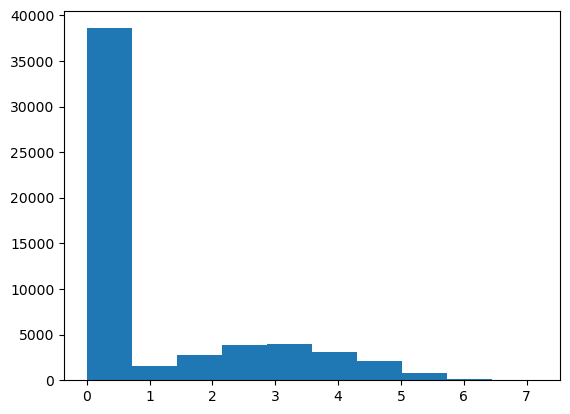

In [26]:
fig1 = plt.hist(np.log(np.clip(X['arr_delay'], 1, None)))
plt.show()

#np.exp(...)

The boxplot shows very large outliers. Let's try using a histogram.

In [27]:
fig = px.histogram(X, x='arr_delay', nbins=500)
fig.show()

Using a histogram with 500 bins, the data does seem to have a normal shape, but we can't be sure at this point. Let's try the normal test next.

In [28]:
normaltest(X['arr_delay'], nan_policy='omit')

NormaltestResult(statistic=81072.8415168131, pvalue=0.0)

Perhaps the outliers are affecting the normal test. Let's try removing them to see if the majority of data is normal.

In [29]:
arr_del = X[X['arr_delay'] < 400]['arr_delay']

In [30]:
arr_del

0        42.0
1        27.0
2         1.0
3       -12.0
4       -22.0
         ... 
58083     1.0
58084    -8.0
58085    -4.0
58086     1.0
58087   -22.0
Name: arr_delay, Length: 56810, dtype: float64

In [31]:
normaltest(arr_del, nan_policy='omit')

NormaltestResult(statistic=44525.81430602235, pvalue=0.0)

The p-value remains at 0.0, indicating that the data is not normally distributed.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [111]:
from datetime import datetime
mon_del = X[['fl_date', 'arr_delay']]

mon_del['fl_date'] = mon_del['fl_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

C:\Users\farha\AppData\Local\Temp\ipykernel_32056\2237589570.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [112]:
mon_del['month'] = mon_del['fl_date'].apply(lambda x: x.month)

C:\Users\farha\AppData\Local\Temp\ipykernel_32056\4065162010.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
mon_del_avg = mon_del.groupby('month').mean().reset_index()
mon_del_avg.head()

,month,arr_delay
0,1,5.067382
1,2,6.432802
2,3,2.151762
3,4,5.982163
4,5,7.188273


In [114]:
px.bar(mon_del_avg, x='month', y='arr_delay')

The largest delays occur during the summer months and the winter months. During the spring and the fall, the delays are smaller. Perhaps this is because of people travelling during the summer months during summer vacation and visiting during the christmas holidays. It is also possible that these are the months with the most extreme weather, windy rainstorms during the summer and snow during the winter.

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [23]:
X.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [116]:
taxi_time

,dep_time,taxi_out
0,1943,16.0
1,2305,20.0
2,1943,19.0
3,2243,12.0
4,626,9.0
...,...,...
58083,1734,15.0
58084,1050,8.0
58085,1440,20.0
58086,625,13.0


In [117]:
# The departure time is formatted as hhmm. 
# get the first two strings to get the hour that a flight departs, 
# and then group by this to find average taxi time
taxi_time = X[['dep_time', 'taxi_out']]
# taxi_time.isna().sum()
taxi_time.dropna(inplace=True)
taxi_time['dep_time'] = taxi_time['dep_time'].apply(lambda x: str(int(x)))

C:\Users\farha\AppData\Local\Temp\ipykernel_32056\2933626390.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\farha\AppData\Local\Temp\ipykernel_32056\2933626390.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [118]:
def get_hour(x):
    if len(x) == 4:
        return int(x[:2])
    return int(x[0])

In [124]:
taxi_time['hour'] = taxi_time['dep_time'].apply(lambda x: get_hour(x))
taxi_avg = taxi_time.groupby('hour').mean().reset_index()
#taxi_avg

C:\Users\farha\AppData\Local\Temp\ipykernel_32056\140818697.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
px.bar(taxi_avg, x='hour', y='taxi_out')

It looks like there is a small dip in taxi time during the early hours of the day after midnight, increasing during the morning around 7 AM. This makes sense as there should be fewer flights during the early morning hours, which people prefer not to fly at these hours.

In [123]:
taxi_count = taxi_time.groupby('hour').count().reset_index()
px.bar(taxi_count, x='hour', y='taxi_out')

Comparing the amount of departures per hour to taxi averages, it looks like the dip in taxi times does correspond to a sharp drop in flights at those hours.

### Average delays throughout the day
Let's look at how average delays are based on the time of day

In [36]:
day_avg = X[['dep_time', 'arr_time', 'arr_delay']]
day_avg.dropna(inplace=True)
day_avg['dep_time'] = day_avg['dep_time'].apply(lambda x: str(int(x)))
day_avg['dep_hour'] = day_avg['dep_time'].apply(lambda x: get_hour(x))
day_avg['arr_time'] = day_avg['arr_time'].apply(lambda x: str(int(x)))
day_avg['arr_hour'] = day_avg['arr_time'].apply(lambda x: get_hour(x))

C:\Users\engwb\anaconda3\envs\lhl-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\engwb\anaconda3\envs\lhl-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\engwb\anaconda3\envs\lhl-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [38]:
dep_hour_count = day_avg.groupby('dep_hour').mean().reset_index()
px.bar(dep_hour_count, x='dep_hour', y='arr_delay')

There seems to be massive delays after 12AM. Why this is the case I'm not sure, but when the flight is leaving seems to be a good indicator of flight delay.

Next, let's check when the flights are scheduled to arrive.

In [39]:
arr_hour_count = day_avg.groupby('arr_hour').mean().reset_index()
px.bar(arr_hour_count, x='arr_hour', y='arr_delay')

It's more or less the same story for scheduled arrival times vs the arrival delay.

However, as seen before there are very few flights during these hours, so these results can be skewed.

In [40]:
arr_hour_amt = day_avg.groupby('arr_hour').count().reset_index()
px.bar(arr_hour_amt, x='arr_hour', y='arr_delay')

### Delays by market carrier
Could the carrier of the affect delays?

In [43]:
X.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [44]:
car_avg = X[['mkt_carrier', 'dep_time', 'arr_time', 'arr_delay']]
car_avg.dropna(inplace=True)
car_avg['dep_time'] = car_avg['dep_time'].apply(lambda x: str(int(x)))
car_avg['dep_hour'] = car_avg['dep_time'].apply(lambda x: get_hour(x))
car_avg['arr_time'] = car_avg['arr_time'].apply(lambda x: str(int(x)))
car_avg['arr_hour'] = car_avg['arr_time'].apply(lambda x: get_hour(x))

C:\Users\engwb\anaconda3\envs\lhl-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\engwb\anaconda3\envs\lhl-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\engwb\anaconda3\envs\lhl-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [60]:
car_del_avg = car_avg.groupby('mkt_carrier').mean().reset_index()

In [61]:
px.bar(car_del_avg, x='mkt_carrier', y='arr_delay')

It seems that some carriers have quite a large average delay, others are small and one is even early on average. This would be a good feature for predicting delays.

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [48]:
dep_del = X[['dep_delay', 'arr_delay']].dropna()

In [49]:
del_avg = dep_del.mean()

In [59]:
px.bar(del_avg)

Looking at the average departure delay versus the average arrival delay, it seems odd that departure delay averages are actually higher than arrival delays. Further investigation is required. We will split the delay between arriving late (positive delay) and arriving early(negative delay)

In [51]:
del_vs_early = dep_del[dep_del > 0].mean()

In [52]:
early_only = dep_del[dep_del < 0].mean()

In [53]:
del_vs_early = pd.concat([del_vs_early, early_only], axis=1)

In [54]:
del_vs_early

,0,1
dep_delay,40.845500,-5.431034
arr_delay,40.523852,-13.702696


In [57]:
px.bar(del_vs_early, color_discrete_sequence=['red', 'blue'])

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?